# Setup og preprocessing

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb


# Inefficient, but keep adding the more dataframes you have, theyll be jioned in the end anyways
df1 = pd.read_excel('Studievejledningens registreringsmodul_ Studreg Enkelt(5001-10000) (1).xlsx')
df2 = pd.read_excel('Studievejledningens registreringsmodul_ Studreg Enkelt(10001-10183) (1).xlsx')

df = pd.concat([df1, df2])

In [45]:
df.info()
df.head()

df['Completion time'] = pd.to_datetime(df["Completion time"])

<class 'pandas.core.frame.DataFrame'>
Index: 5183 entries, 0 to 182
Data columns (total 36 columns):
 #   Column                                                                                Non-Null Count  Dtype         
---  ------                                                                                --------------  -----         
 0   ID                                                                                    5183 non-null   int64         
 1   Start time                                                                            5183 non-null   datetime64[ns]
 2   Completion time                                                                       5183 non-null   datetime64[ns]
 3   Email                                                                                 5183 non-null   object        
 4   Name                                                                                  5183 non-null   object        
 5   Type                                    

In [46]:
df = df[['Completion time', 'Type', 'Studieretning', 'Emne']]

# Change these variables according with the semester.
# I.E for fall use 1. september - 31 january
# Spring use 1. february - 31 August.
# TODO, make them constant variables

start_date = '9/1/24 00:00:00'
end_date = '1/31/25 00:00:00'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

mask = (df['Completion time'] >= start_date) & (df['Completion time'] <= end_date)
df_subset = df.loc[mask]

# Hvor mange søger vejledning i alt

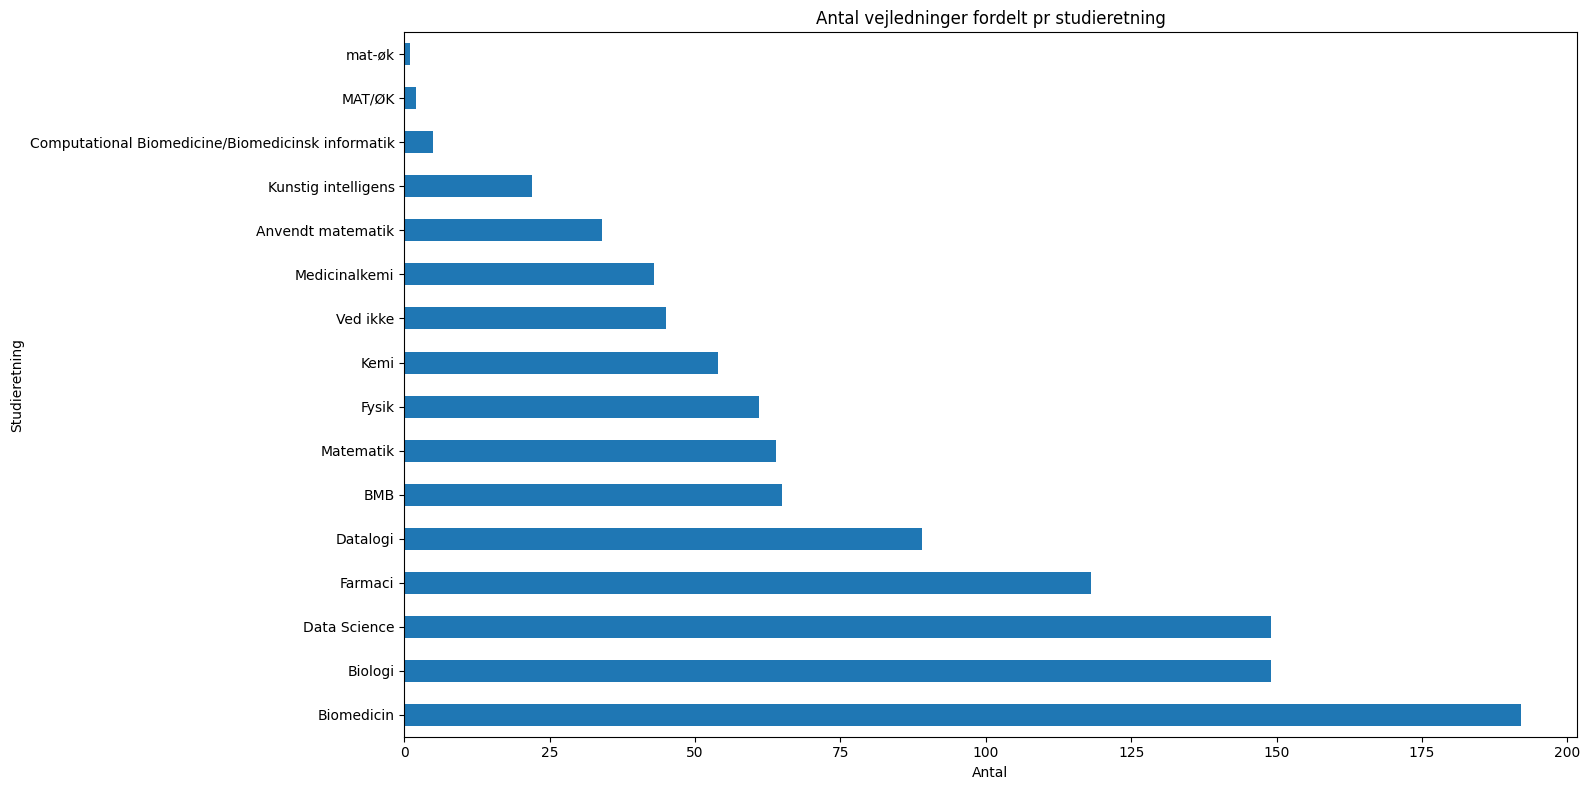

In [64]:
ax = (df_subset['Studieretning']
 .value_counts()
 .plot(
     kind='barh',
     figsize=(16,8),
     title="Antal vejledninger fordelt pr studieretning",
     xlabel="Antal"
 ))
plt.tight_layout()
ax.figure.savefig('AntalVejledningFordeltPrStudieretning.png')

# Hvor mange søger vejledning per type

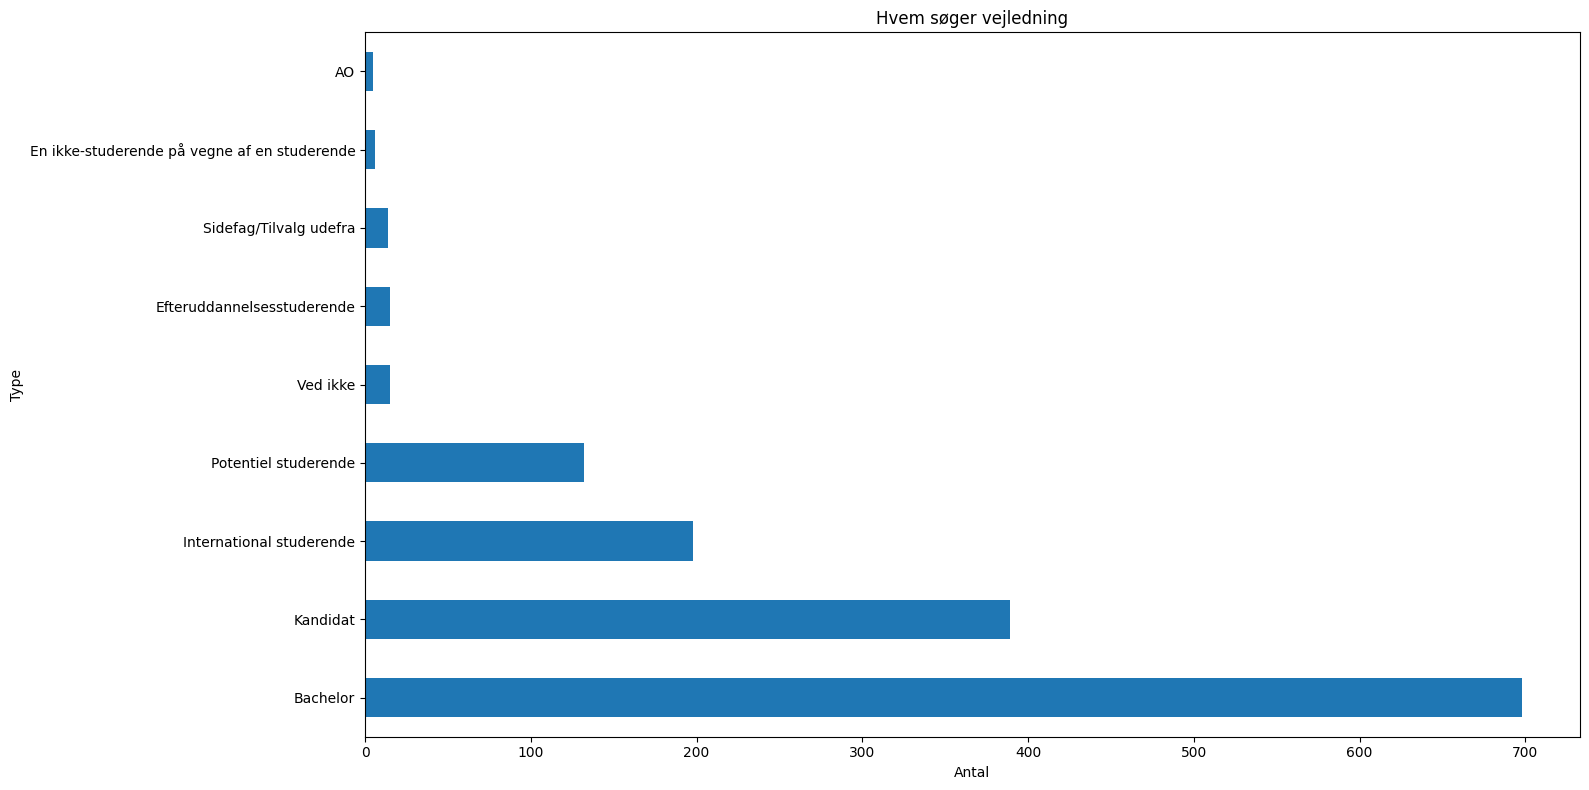

In [63]:
ax = df_subset['Type'].value_counts().plot(kind='barh', figsize=(16,8), title="Hvem søger vejledning", xlabel="Antal")
plt.tight_layout()
ax.figure.savefig('TyperAfStuderendeSomSøgerVejledning.png')

# Hvor mange søger vejledning per studieretning per bachelor og kandidat

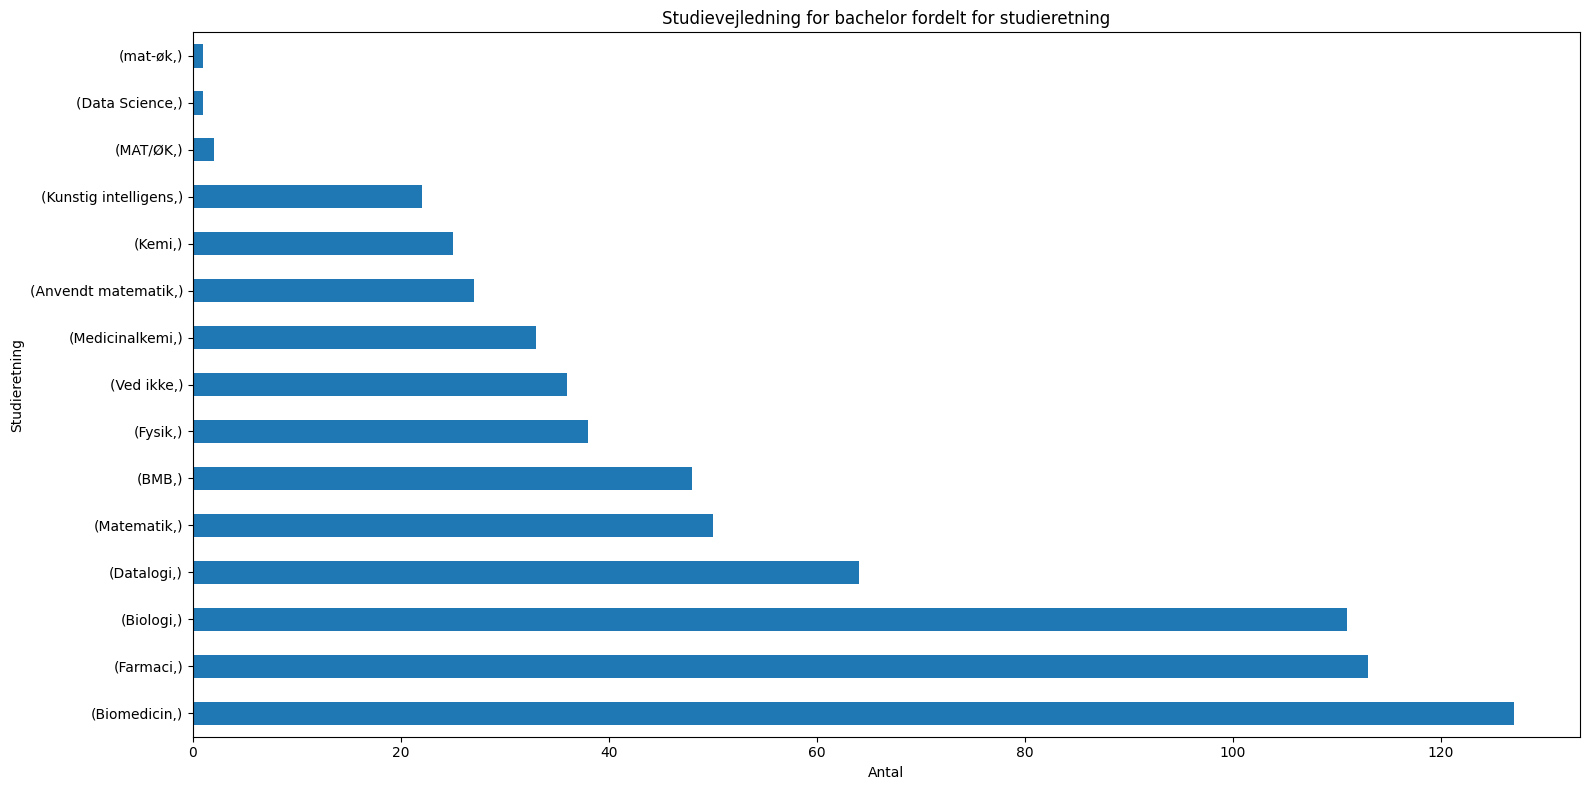

In [62]:
ax = df_subset.loc[df['Type'] == 'Bachelor', ['Studieretning']].value_counts().plot(kind='barh', figsize=(16,8), title="Studievejledning for bachelor fordelt for studieretning", xlabel="Antal")
plt.tight_layout()
ax.figure.savefig('StudievejledningerForBachelorPrStudieretning.png')

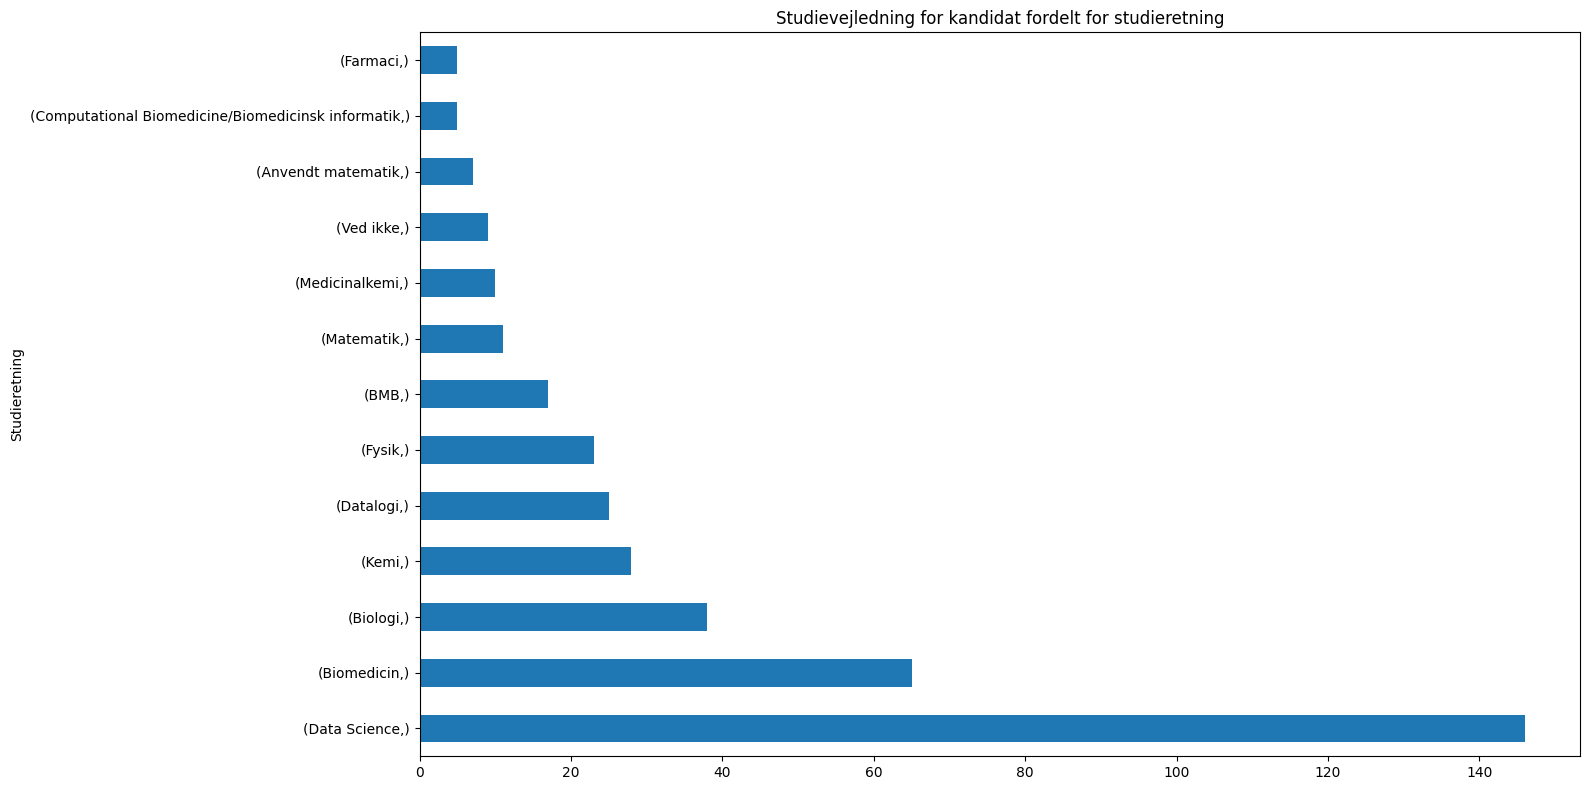

In [61]:
ax = (df_subset
 .loc[df_subset['Type'] == 'Kandidat', ['Studieretning']]
 .value_counts()
 .plot(kind='barh',
       figsize=(16,8),
       title='Studievejledning for kandidat fordelt for studieretning'))

plt.tight_layout()

ax.figure.savefig('StudievejledningForKandidatPrStudieretning.png')

# Hvor mange søger hjælp pr emne

In [51]:
df_exploded = df_subset.assign(Emne=df_subset['Emne'].str.split(';')).explode('Emne')

print(df_exploded)

         Completion time      Type Studieretning                    Emne
2798 2024-09-02 09:06:03  Kandidat    Biomedicin          Valg undervejs
2798 2024-09-02 09:06:03  Kandidat    Biomedicin        Kursustilmelding
2798 2024-09-02 09:06:03  Kandidat    Biomedicin                        
2799 2024-09-02 09:06:19  Bachelor    Biomedicin        Kursustilmelding
2799 2024-09-02 09:06:19  Bachelor    Biomedicin                        
...                  ...       ...           ...                     ...
4267 2025-01-30 10:51:07  Kandidat  Data Science                        
4268 2025-01-30 14:14:09  Bachelor       Farmaci                 Eksamen
4268 2025-01-30 14:14:09  Bachelor       Farmaci                        
4269 2025-01-30 14:15:05  Bachelor      Datalogi  Mistrivsel (Husk note)
4269 2025-01-30 14:15:05  Bachelor      Datalogi                        

[2923 rows x 4 columns]


In [52]:
df_exploded = df_exploded.loc[df_exploded['Emne'] != ""]

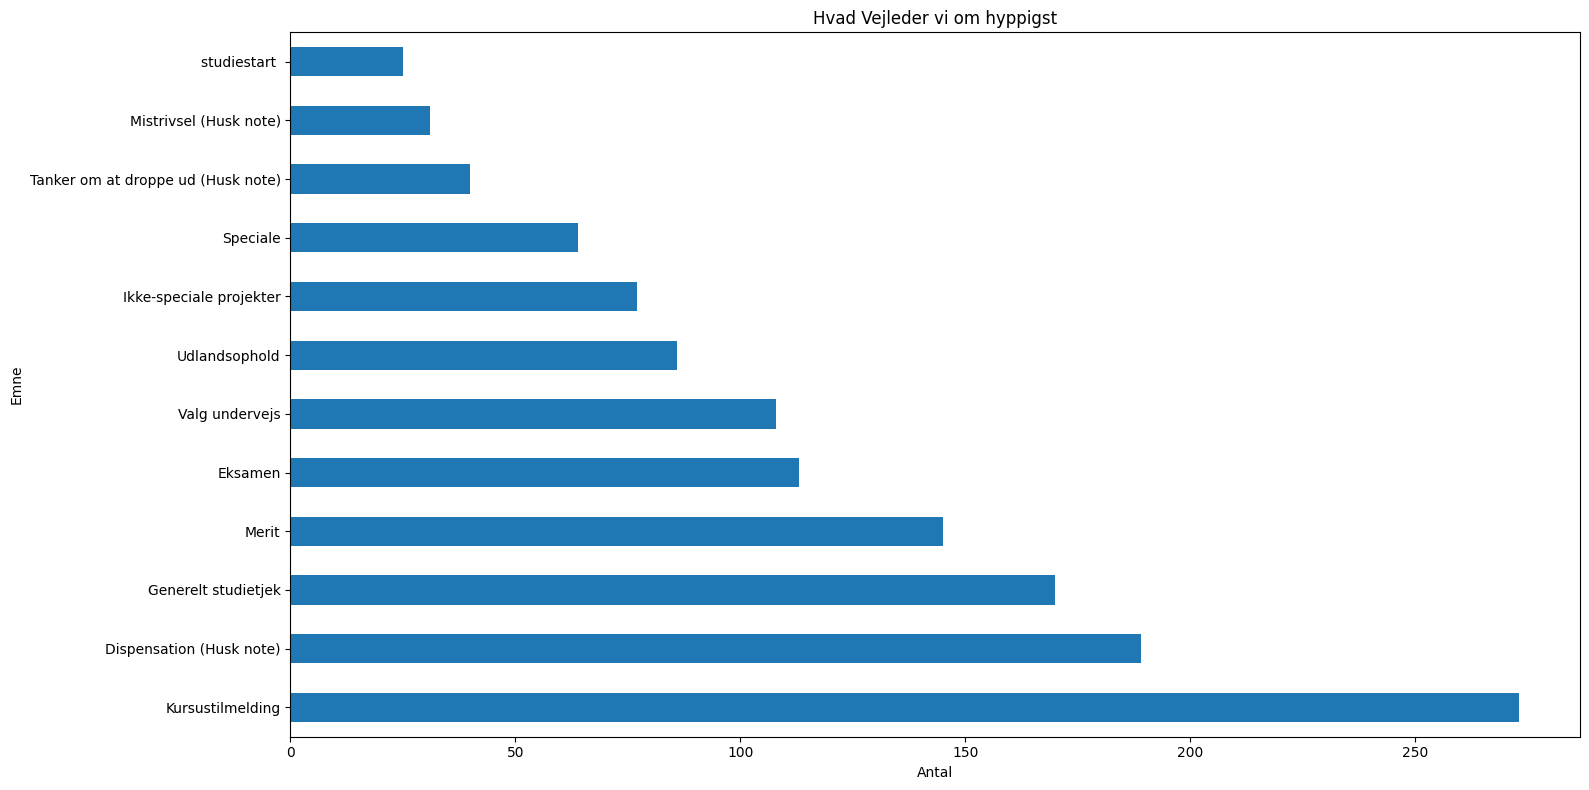

In [65]:
#(df_exploded['Emne'].value_counts()
 #.loc[lambda x: x > 10] # Filter alle større end 10
 #.index
 #.pipe(lambda frequent: df_exploded[df_exploded['Emne'].isin(frequent)])
 #['Emne'].value_counts()
 #.plot(kind='barh', figsize=(16,8)))


ax= (df_exploded['Emne'].value_counts()
 .loc[lambda x: x>10]
 .plot(
     kind='barh',
     figsize=(16,8),
     title="Hvad Vejleder vi om hyppigst",
     xlabel="Antal"
 ))
plt.tight_layout()
ax.figure.savefig('HyppigsteEmnerDerblivervejledt.png')

# Hvilken type emne er mest forkommende pr studieretning

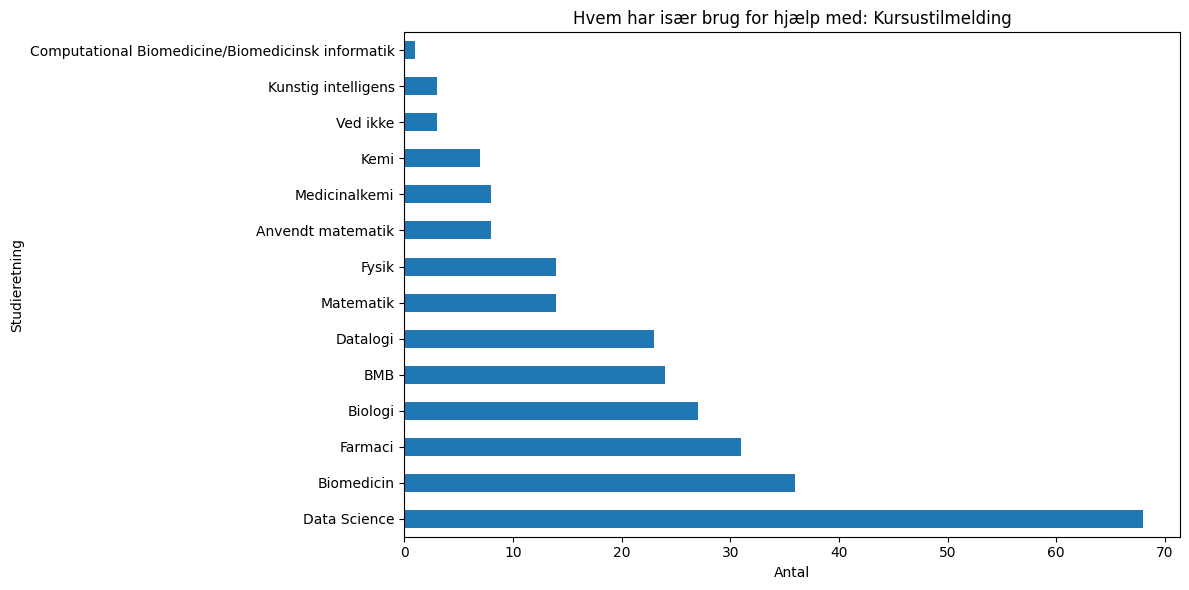

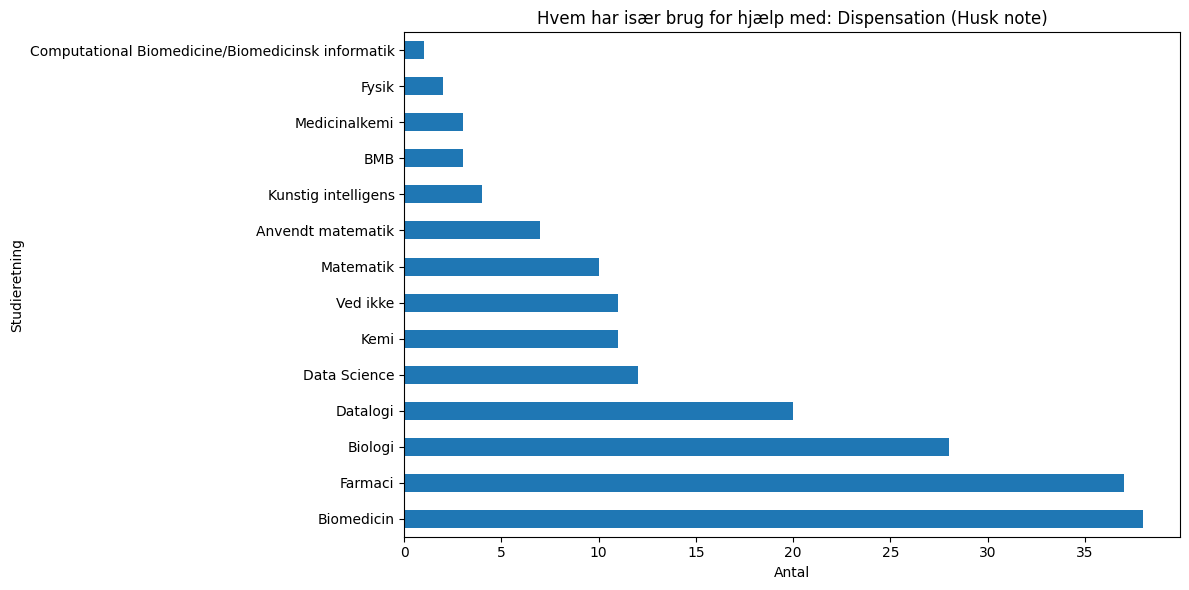

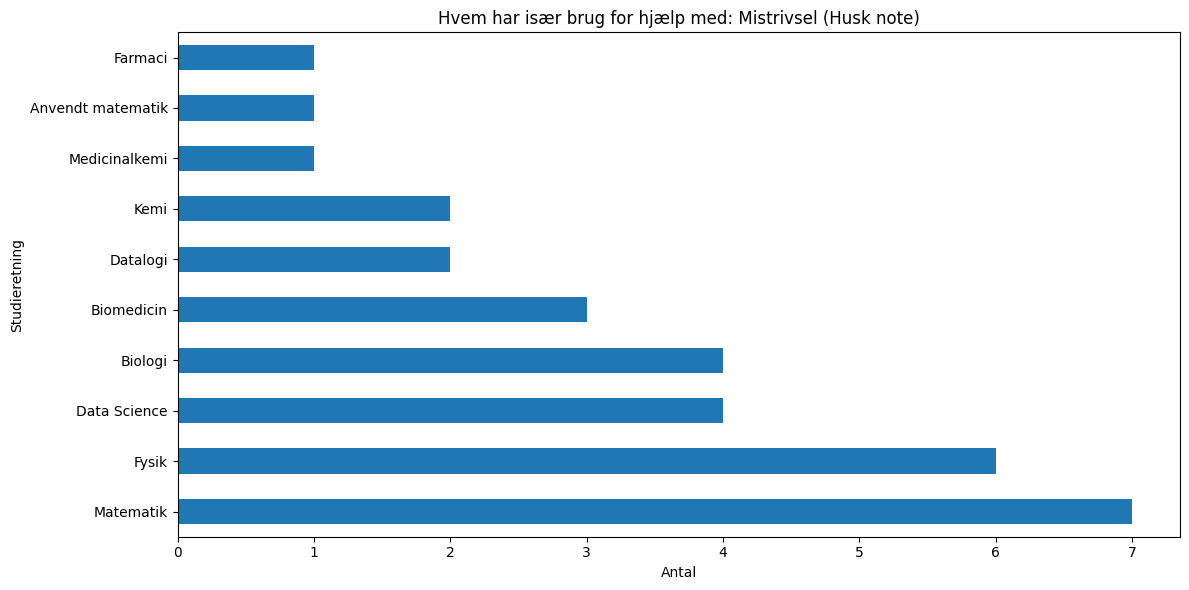

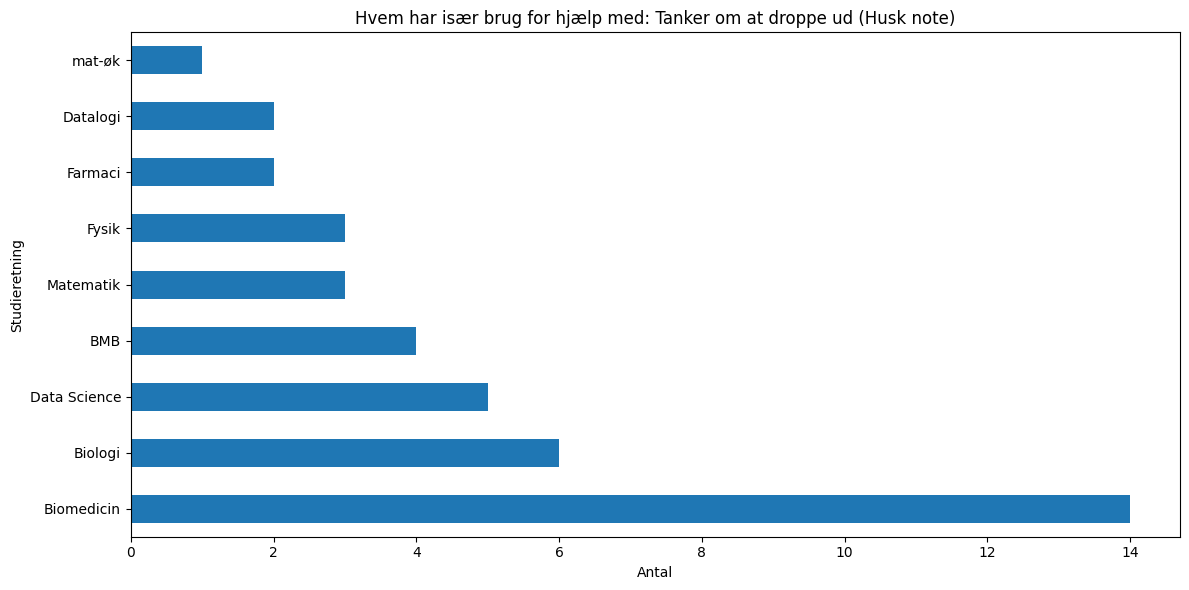

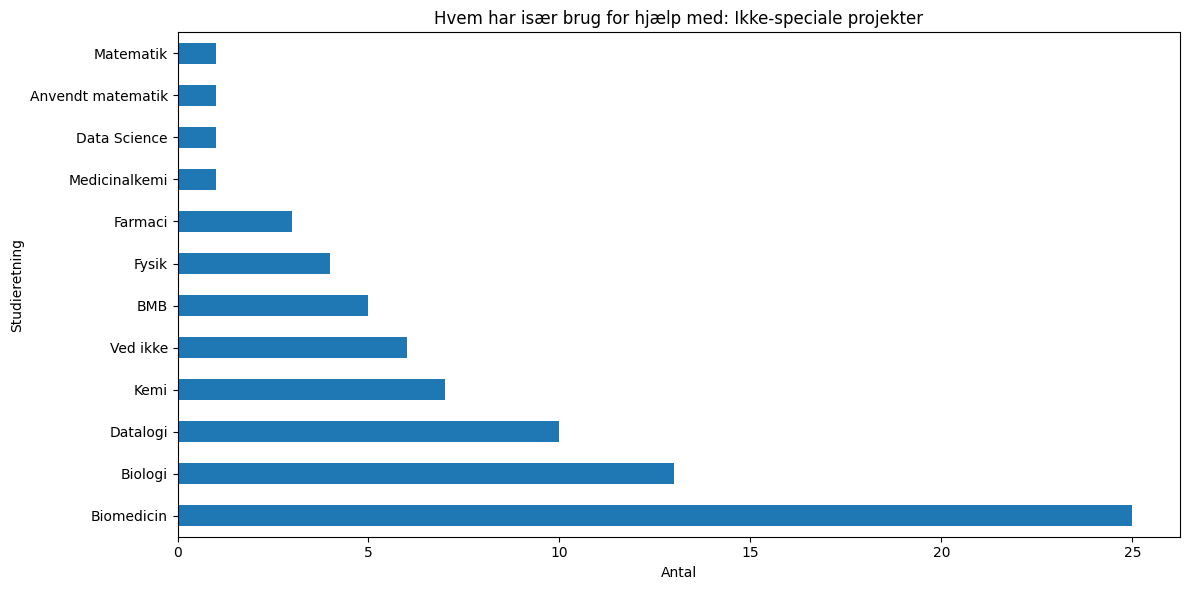

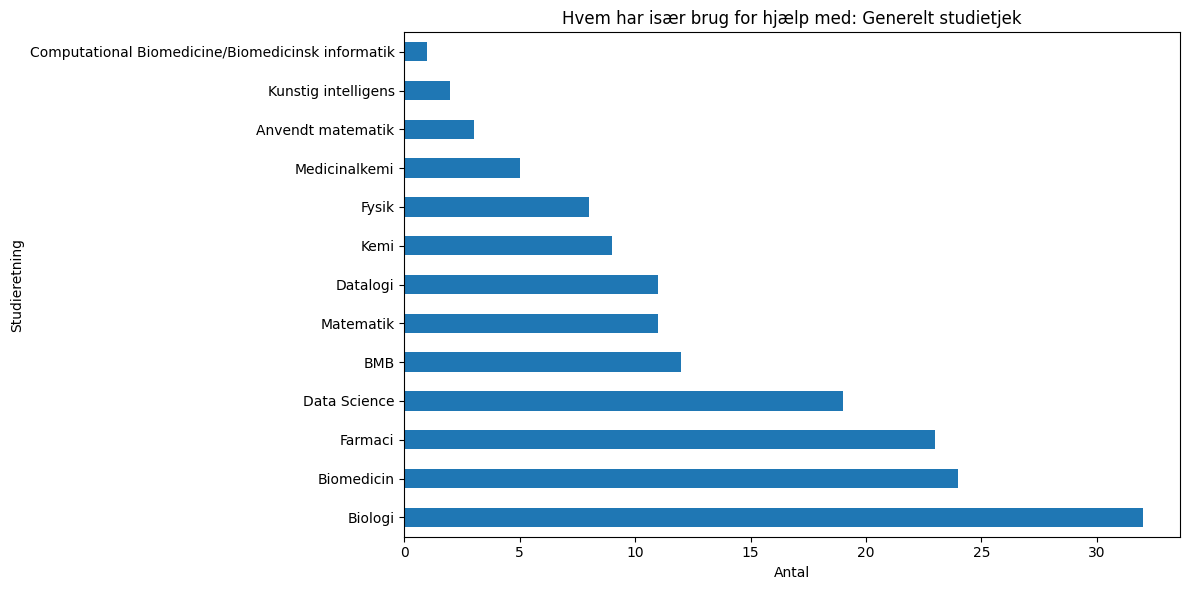

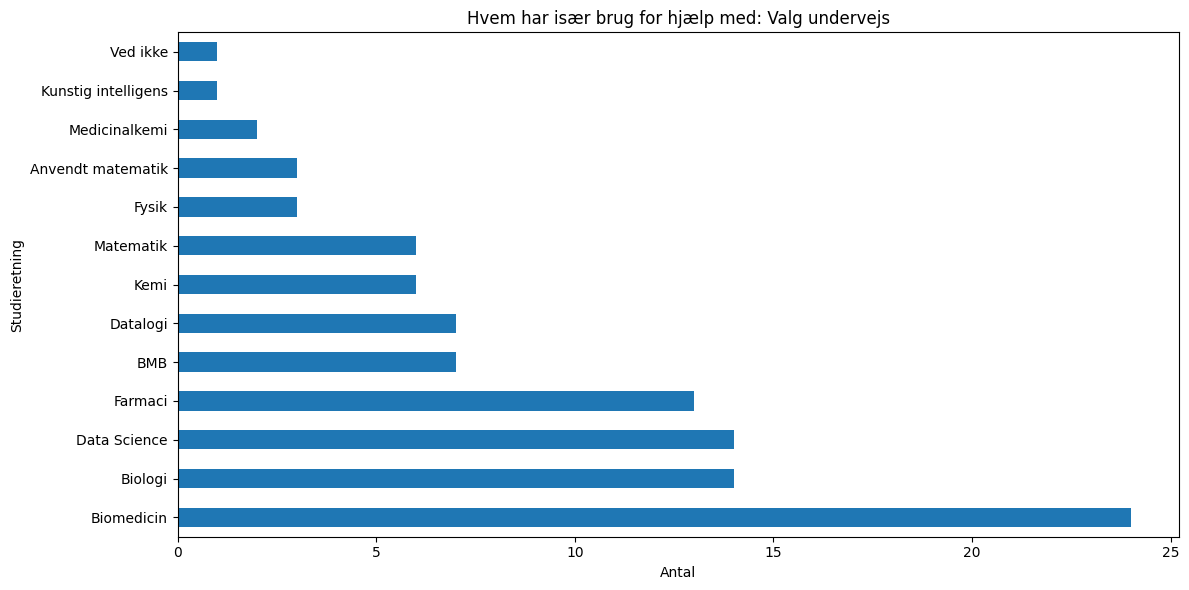

In [58]:
import matplotlib.pyplot as pyplt

def test(ds, tema):
    temp = ds[ds['Emne'] == tema]
    if not temp.empty:
        pyplt.figure(figsize=(12,6))
        temp['Studieretning'].value_counts().plot(kind='barh')
        pyplt.xlabel('Antal')
        pyplt.ylabel('Studieretning')
        pyplt.title(f"Hvem har især brug for hjælp med: {tema}")
        pyplt.tight_layout()
        pyplt.savefig(f'Hvem har især brug for hjælp med: {tema}.png')
        pyplt.show()
    else:
        print(f"No data found for tema: {tema}")

tema_list = ['Kursustilmelding',
             'Dispensation (Husk note)',
             'Mistrivsel (Husk note)',
             'Tanker om at droppe ud (Husk note)',
             'Ikke-speciale projekter',
             'Generelt studietjek',
             'Valg undervejs']

for i in tema_list:
    test(df_exploded.copy(), i)

# Random stats

### Chi-square test

In [55]:
import scipy.stats as sc

In [56]:
data = df_exploded

studieretning = df_exploded['Studieretning'].unique()

    
def stats(data, tema, studie):
    # Creating a 2x2 table

    # number of rows where Emne == emne og Studieretning == Studieretning
    a = ((data['Emne'] == tema) & (data['Studieretning'] == studie)).sum()

    # Number of rows where emne == emne and studieretning != studieretning

    b = ((data['Emne'] == tema) & (data['Studieretning'] != studie)).sum()

    # number of rows where Emne != Emne and Studieretning == Studie
    c = ((data['Emne'] != tema) & (data['Studieretning'] == studie)).sum()

    # Number of rows where Emne != Emne and Studieretning != Studie
    d = ((data['Emne'] != tema) & (data['Studieretning'] != studie)).sum()

    return [[a, b],
            [c, d]]

for i in tema_list:
    print(f"Testing in {i}")
    for j in studieretning:
        results = stats(data, i, j)
        try:
            stat, p, dof, expected = sc.chi2_contingency(results)
            if (p < 0.05):
                print(f"P-value: {p} for {i} in {j}")
            else:
                print(f"P-value not significant for {i} in {j}")
        except ValueError as e:
            if "expected frequencies has a zero element" in str(e):
                print(f"Skipped {i} in {j} due to zero expected frequency")
            else:
                raise
    print("\n")


Testing in Kursustilmelding
P-value not significant for Kursustilmelding in Biomedicin
P-value not significant for Kursustilmelding in Medicinalkemi
P-value not significant for Kursustilmelding in Anvendt matematik
P-value not significant for Kursustilmelding in Fysik
P-value not significant for Kursustilmelding in Farmaci
P-value not significant for Kursustilmelding in Biologi
Skipped Kursustilmelding in nan due to zero expected frequency
P-value not significant for Kursustilmelding in Datalogi
P-value: 0.0024098363014301884 for Kursustilmelding in BMB
P-value not significant for Kursustilmelding in Matematik
P-value not significant for Kursustilmelding in Kemi
P-value: 1.599385103817517e-14 for Kursustilmelding in Data Science
P-value not significant for Kursustilmelding in Computational Biomedicine/Biomedicinsk informatik
P-value not significant for Kursustilmelding in Ved ikke
P-value not significant for Kursustilmelding in Kunstig intelligens
P-value not significant for Kursustilm